In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder




In [2]:
# Import train and test data
train_data = pd.read_csv('/Users/Checkout/Desktop/Github Projects/ML in Human Activity Recognition/Data/train.csv')
test_data = pd.read_csv('/Users/Checkout/Desktop/Github Projects/ML in Human Activity Recognition/Data/test.csv')


In [3]:
# Visualize the data

train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [4]:
# Subject is same for all the activities and hence we can drop it from the dataset and activity is the target variable

# Dropping subject and activity from train data
X_train = train_data.drop(['subject', 'Activity'], axis=1)
y_train = train_data['Activity']

#  Doing the same to test data 
X_test = test_data.drop(['subject', 'Activity'], axis=1)
y_test = test_data['Activity']


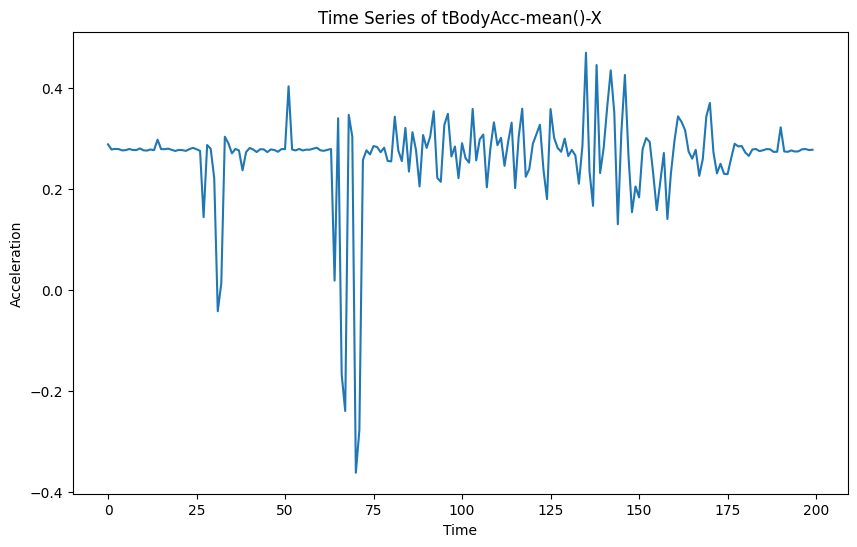

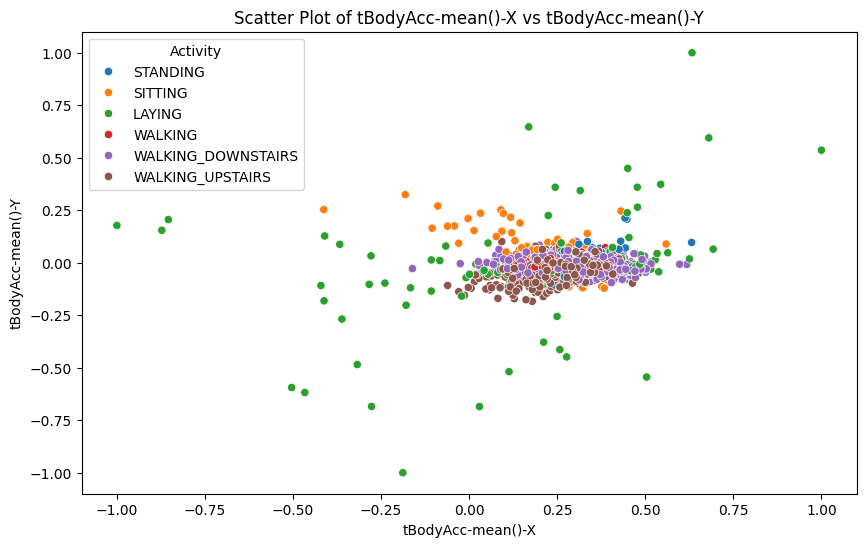

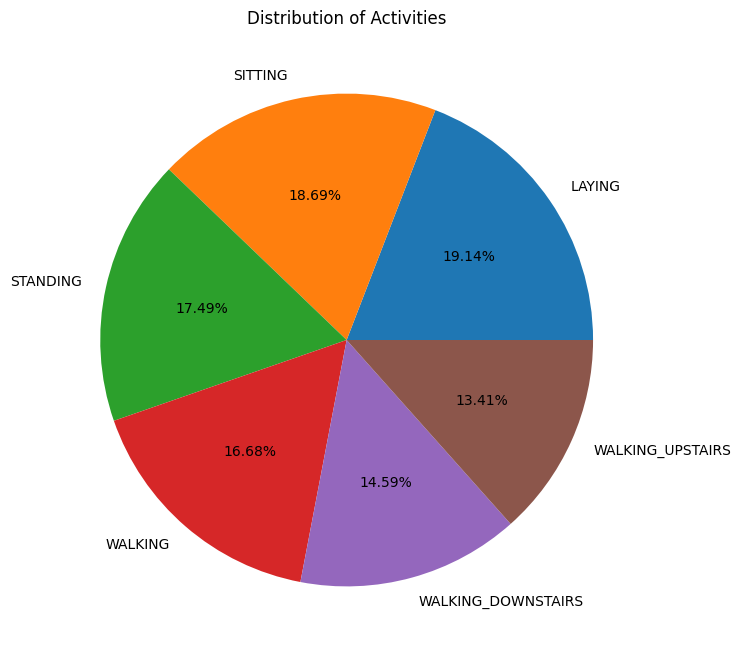

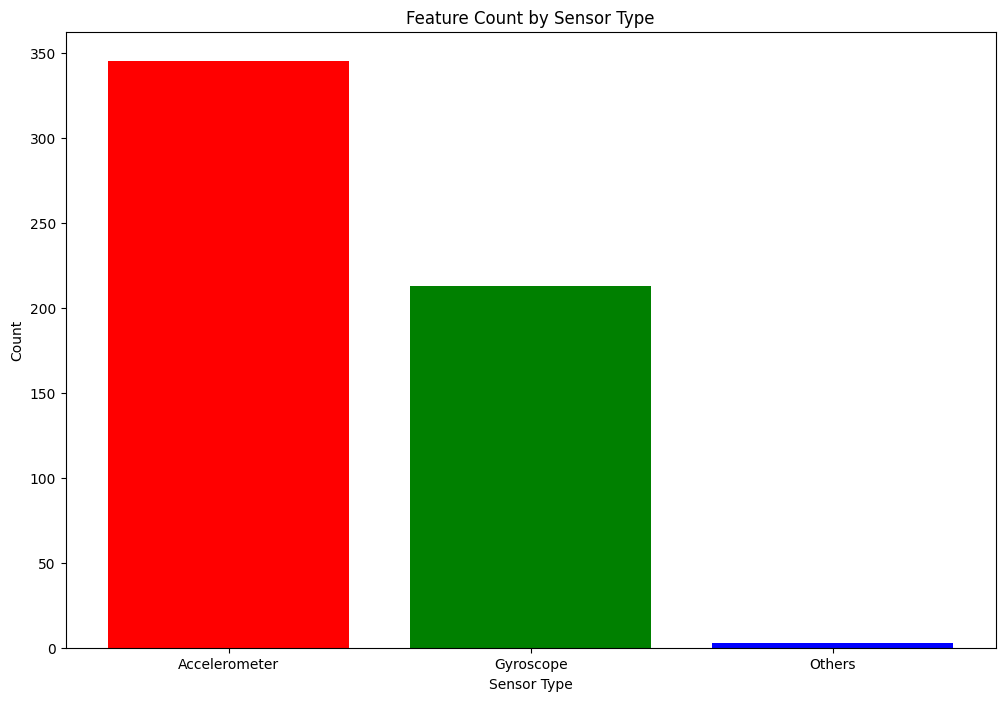

In [5]:
# explore the data 
# Line Plot for Time-Series Data
plt.figure(figsize=(10, 6))
plt.plot(train_data['tBodyAcc-mean()-X'][:200])  # Plotting first 200 data points
plt.title('Time Series of tBodyAcc-mean()-X')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.show()


# Scatter Plot for Comparing Two Sensors
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tBodyAcc-mean()-X', y='tBodyAcc-mean()-Y', data=train_data, hue='Activity')
plt.title('Scatter Plot of tBodyAcc-mean()-X vs tBodyAcc-mean()-Y')
plt.show()


count = np.array(y_train.value_counts())
activities = sorted(y_train.unique())

# Creating the pie chart
plt.figure(figsize=(16, 8))
plt.pie(count, labels=activities, autopct='%0.2f%%')  # Updated to show percentage

# Adding a title (optional)
plt.title('Distribution of Activities')

# Show the plot
plt.show()


# Accelorometer has higher count than Gyroscope
# Initialize counts
Acc = Gyro = other = 0

# Iterate through columns and count occurrences
for value in X_train.columns:
    if "Acc" in value:
        Acc += 1
    elif "Gyro" in value:
        Gyro += 1
    else:
        other += 1

# Creating a bar chart
plt.figure(figsize=(12, 8))
plt.bar(['Accelerometer', 'Gyroscope', 'Others'], [Acc, Gyro, other], color=['r', 'g', 'b'])
plt.title('Feature Count by Sensor Type')
plt.xlabel('Sensor Type')
plt.ylabel('Count')
plt.show()

In [6]:
# Define models and their parameter grids
def get_models_and_params():
    """
    Defines the models and their parameter grids for training.
    This allows easy addition or modification of models and their parameters.

    Returns:
        dict, dict: Two dictionaries, one for models and another for parameters.
    """
    models = {
        "Random Forest": RandomForestClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Logistic Regression": LogisticRegression(),
        "XGBClassifier": XGBClassifier(),
        "AdaBoost Classifier": AdaBoostClassifier(),
    }
    params = {
        "Random Forest": {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, None]},
        "Decision Tree": {'criterion': ['gini', 'entropy']},
        "Gradient Boosting": {'learning_rate': [0.1, 0.01], 'n_estimators': [100, 200]},
        "Logistic Regression": {'C': [0.1, 1, 10]},
        "XGBClassifier": {'learning_rate': [0.1, 0.01], 'n_estimators': [100, 200]},
        "AdaBoost Classifier": {'learning_rate': [0.1, 0.01], 'n_estimators': [50, 100]},
    }
    return models, params

In [7]:
# Train models and evaluate their performance
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    """
    Train multiple models and evaluate their performance.
    Args:
        X_train, y_train: Training data and labels.
        X_test, y_test: Testing data and labels.
    """
    best_model_accuracy , best_model_name = 0, ""
    models, params = get_models_and_params()
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Creating a grid search object for the model 
        clf = GridSearchCV(model, params[name], cv=5)
        
        # Instantiate the label encoder
        label_encoder = LabelEncoder()

        # Encode the labels to integers
        y_train = label_encoder.fit_transform(y_train)
        y_test = label_encoder.transform(y_test)

# Now, you can use y_train_encoded and y_test_encoded for training and evaluation
        # Fitting the model
        clf.fit(X_train, y_train)
        print(f"Best parameters for {name}: {clf.best_params_}")
        
        # Predicting the labels and evaluating the model
        y_pred = clf.predict(X_test)
        print(f"Classification Report for {name}:\n{classification_report(y_test, y_pred)}")

        # Calculating the accuracy score
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy}")
        
        # store the best model and its accuracy
        if accuracy > best_model_accuracy:
            best_model_accuracy = accuracy
            best_model_name = name
        
        # Plotting the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True)
        plt.title(f"Confusion Matrix for {name}")
        plt.show()
        
    print(f"The best model is {best_model_name} with accuracy {best_model_accuracy}")
        

Training Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.92      0.88      0.90       491
           2       0.89      0.93      0.91       532
           3       0.89      0.96      0.92       496
           4       0.96      0.83      0.89       420
           5       0.89      0.91      0.90       471

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947

Random Forest Accuracy: 0.9226331862911435


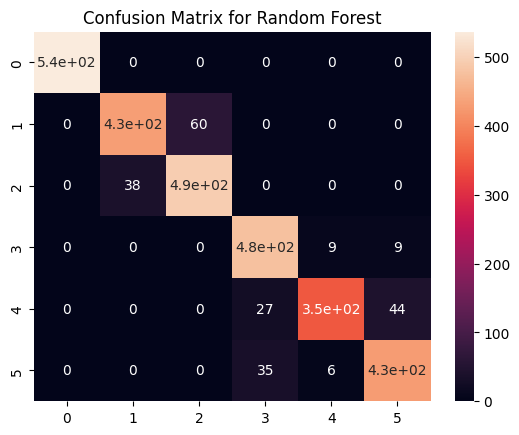

Training Decision Tree...
Best parameters for Decision Tree: {'criterion': 'entropy'}
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.82      0.76      0.79       491
           2       0.79      0.85      0.82       532
           3       0.83      0.93      0.88       496
           4       0.84      0.85      0.84       420
           5       0.83      0.72      0.77       471

    accuracy                           0.85      2947
   macro avg       0.85      0.85      0.85      2947
weighted avg       0.85      0.85      0.85      2947

Decision Tree Accuracy: 0.8530709195792331


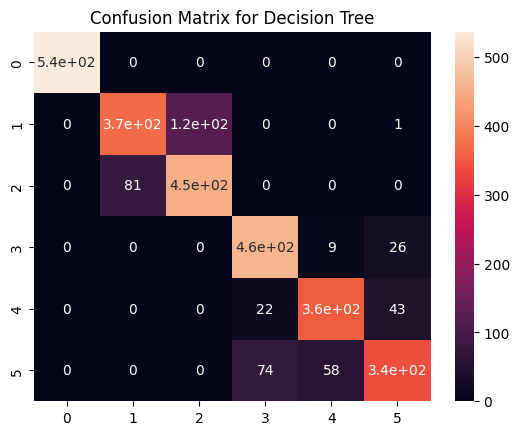

Training Logistic Regression...


/Users/Checkout/Desktop/Github Projects/ML in Human Activity Recognition/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Checkout/Desktop/Github Projects/ML in Human Activity Recognition/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documenta

Best parameters for Logistic Regression: {'C': 1}
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.96      0.88      0.92       491
           2       0.90      0.97      0.93       532
           3       0.95      0.99      0.97       496
           4       0.99      0.96      0.97       420
           5       0.96      0.94      0.95       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947

Logistic Regression Accuracy: 0.9579233118425518


/Users/Checkout/Desktop/Github Projects/ML in Human Activity Recognition/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


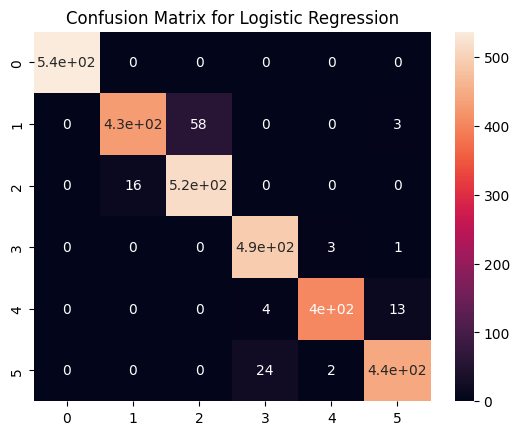

Training XGBClassifier...
Best parameters for XGBClassifier: {'learning_rate': 0.1, 'n_estimators': 200}
Classification Report for XGBClassifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.93      0.85      0.89       491
           2       0.88      0.94      0.91       532
           3       0.92      0.98      0.95       496
           4       0.97      0.91      0.94       420
           5       0.92      0.92      0.92       471

    accuracy                           0.93      2947
   macro avg       0.94      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947

XGBClassifier Accuracy: 0.9338310145911096


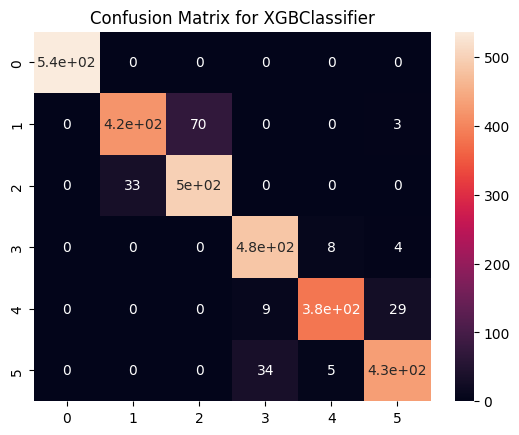

Training AdaBoost Classifier...
Best parameters for AdaBoost Classifier: {'learning_rate': 0.01, 'n_estimators': 100}
Classification Report for AdaBoost Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.58      0.25      0.35       491
           2       0.55      0.83      0.66       532
           3       0.63      0.91      0.75       496
           4       0.94      0.60      0.73       420
           5       0.80      0.69      0.74       471

    accuracy                           0.72      2947
   macro avg       0.75      0.71      0.71      2947
weighted avg       0.75      0.72      0.71      2947

AdaBoost Classifier Accuracy: 0.7234475738038684


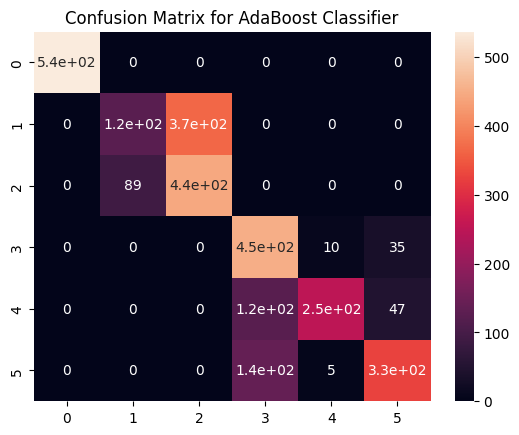

The best model is Logistic Regression with accuracy 0.9579233118425518


In [8]:
# Train and evaluate models
train_and_evaluate_models(X_train, y_train, X_test, y_test)